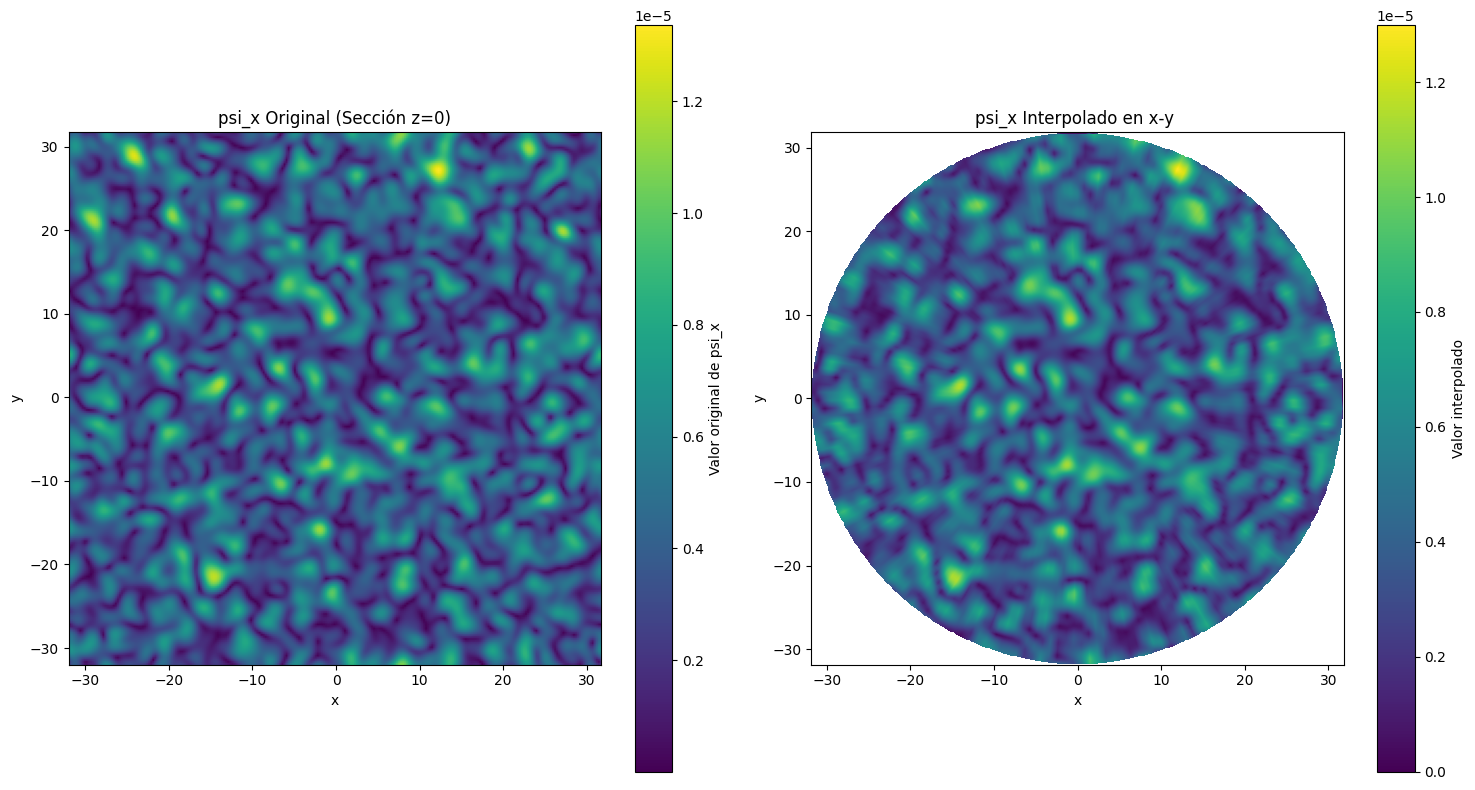

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator, griddata

# Función de interpolación en coordenadas esféricas
def interpolar_a_coordenadas_esfericas(x, y, z, rho, Nr, Nt, Np):
    # Calcular el radio máximo basado en el dominio original
    r_max = np.max([np.max(x) - np.min(x), np.max(y) - np.min(y)]) / 2

    # Convertir coordenadas cartesianas a esféricas
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arccos(z / np.maximum(r, 1.0e-12))  # Ángulo polar
    phi = np.arctan2(y, x)  # Ángulo azimutal

    r_new = np.linspace(0.0, r_max, Nr)
    theta_new = np.linspace(0.0, np.pi, Nt)
    phi_new = np.linspace(0.0, 2.0 * np.pi, Np)
    R, Theta, Phi = np.meshgrid(r_new, theta_new, phi_new, indexing='ij')

    # Convertir coordenadas esféricas a cartesianas
    x_new = R * np.sin(Theta) * np.cos(Phi)
    y_new = R * np.sin(Theta) * np.sin(Phi)
    z_new = R * np.cos(Theta)

    # Crear interpolador en la malla cartesiana original
    interpolator = RegularGridInterpolator((np.linspace(np.min(x), np.max(x), x.shape[0]), 
                                            np.linspace(np.min(y), np.max(y), y.shape[0]), 
                                            np.linspace(np.min(z), np.max(z), z.shape[0])), 
                                           rho, method='linear', bounds_error=False, fill_value=0)

    # Interpolar valores en la nueva malla
    points = np.stack([x_new.flatten(), y_new.flatten(), z_new.flatten()], axis=-1)
    rho_interp_flat = interpolator(points)
    rho_interp = rho_interp_flat.reshape((Nr, Nt, Np)) * np.sin(Theta)

    return rho_interp, R, Phi, r_max


# Leer los datos del archivo
datos = np.loadtxt('random_cart.dat')

# Reorganizar los datos en un arreglo tridimensional de dimensiones (Nx, Ny, Nz, 4)
Nx, Ny, Nz = 256, 256, 256  # Ajusta según el dominio original
omega = datos.reshape(Nx, Ny, Nz, 4)

# Asignar las coordenadas y la función a interpolar
x = omega[:, :, :, 0]  # x
y = omega[:, :, :, 1]  # y
z = omega[:, :, :, 2]  # z
psi_x = omega[:, :, :, 3]  # abs(psi_x)

Nr, Nt, Np = 600, 200, 200  # Aumentar resolución

# Interpolar en coordenadas esféricas
psi_int, R, Phi, r_max = interpolar_a_coordenadas_esfericas(x, y, z, psi_x, Nr, Nt, Np)

# Seleccionar el índice correcto para \(\theta = \pi/2\)
theta_index = np.argmin(np.abs(np.pi / 2 - np.linspace(0, np.pi, Nt)))

# Extraer la función interpolada en el plano ecuatorial
psi_int_section = psi_int[:, theta_index, :]

# Convertir a coordenadas cartesianas
X_interp = R[:, theta_index, :] * np.cos(Phi[:, theta_index, :])
Y_interp = R[:, theta_index, :] * np.sin(Phi[:, theta_index, :])

# Aplicar máscara para restringir valores dentro del círculo esperado
mask = R[:, theta_index, :] <= r_max
X_interp = X_interp[mask]
Y_interp = Y_interp[mask]
psi_int_section = psi_int_section[mask]

# Seleccionar la sección \(z=0\) de los datos originales
z_index = Nz // 2
psi_x_section = psi_x[:, :, z_index]

# Crear malla cartesiana para la visualización
grid_x, grid_y = np.mgrid[-r_max:r_max:600j, -r_max:r_max:600j]

# Interpolar la función interpolada en una malla cartesiana usando 'linear'
grid_z = griddata((X_interp, Y_interp), psi_int_section, (grid_x, grid_y), method='linear')

# Aplicar una máscara para ocultar valores fuera del círculo
grid_r = np.sqrt(grid_x**2 + grid_y**2)
grid_z[grid_r > r_max] = np.nan  # Asigna NaN fuera del círculo para ocultarlos en la gráfica

# Crear subgráficas para comparar ambos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

# Mapa de color de la función original en coordenadas cartesianas
c1 = ax1.imshow(psi_x_section, origin='lower', extent=[np.min(x), np.max(x), np.min(y), np.max(y)], cmap='viridis')
fig.colorbar(c1, ax=ax1, label='Valor original de psi_x')
ax1.set_title('psi_x Original (Sección z=0)')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

# Mapa de color de la función interpolada después de transformarla a una grilla cartesiana
c2 = ax2.imshow(grid_z, origin='lower', extent=[-r_max, r_max, -r_max, r_max], cmap='viridis')
fig.colorbar(c2, ax=ax2, label='Valor interpolado')
ax2.set_title('psi_x Interpolado en x-y ')
ax2.set_xlabel('x')
ax2.set_ylabel('y')

plt.tight_layout()
plt.show()
